In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import Symbol, diff, solve, nsolve, solveset, latex, S, simplify, fraction, Union, Interval, intersection, limit
from sympy.calculus.util import continuous_domain
from sympy import sin as Sin
from sympy import cos as Cos
from sympy import pi as Pi
%matplotlib inline

In [2]:
class input_data:
  def __init__(this, data):
    this.input_data = data.split("\n")
    this.last_used_index = -1
  def get_input(this, question):
    this.last_used_index = this.last_used_index + 1
    if (this.last_used_index >= len(this.input_data)):
      this.input_data.append(input(question))
    else:
      print(f"""{question}{this.input_data[this.last_used_index]}""")
    return(this.input_data[this.last_used_index])
  def read_expression(this, question):
    expr = this.get_input(question)
    return(sympy.parse_expr(expr))

In [3]:
class graph:
  def __init__(this):
    this.ax = plt.gca()
  def normalize(this):
    this.ax.set_aspect('equal')
    this.ax.spines['right'].set_color('none')
    this.ax.spines['top'].set_color('none')
    this.ax.set_xlabel("x")
    this.ax.set_ylabel("y")
    dx = this.ax.get_xlim()[1] - this.ax.get_xlim()[0]
    dy = this.ax.get_ylim()[1] - this.ax.get_ylim()[0]

    if (this.ax.get_ylim()[0] > 0 and this.ax.get_ylim()[1] > 0):
      this.ax.spines['bottom'].set_position(('data', this.ax.get_ylim()[0]))
      this.ax.plot(1, this.ax.get_ylim()[0], ">k", transform=this.ax.get_yaxis_transform(), clip_on=False)
      this.ax.xaxis.set_label_coords(1, -1.25 * dy / 40 + this.ax.get_ylim()[0], transform=this.ax.get_yaxis_transform())
    elif (this.ax.get_ylim()[0] < 0 and this.ax.get_ylim()[1] < 0):
      this.ax.spines['bottom'].set_position(('data', this.ax.get_ylim()[1]))
      this.ax.plot(1, this.ax.get_ylim()[1], ">k", transform=this.ax.get_yaxis_transform(), clip_on=False)
      this.ax.xaxis.set_label_coords(1, -1.25 * dy / 40 + this.ax.get_ylim()[1], transform=this.ax.get_yaxis_transform())
    else:
      this.ax.spines['bottom'].set_position(('data', 0))
      this.ax.plot(1, 0, ">k", transform=this.ax.get_yaxis_transform(), clip_on=False)
      this.ax.xaxis.set_label_coords(1, -1.25 * dy / 40, transform=this.ax.get_yaxis_transform())

    if (this.ax.get_xlim()[0] > 0 and this.ax.get_xlim()[1] > 0):
      this.ax.spines['left'].set_position(('data', this.ax.get_xlim()[0]))
      this.ax.plot(this.ax.get_xlim()[0], 1, "^k", transform=this.ax.get_xaxis_transform(), clip_on=False)
      this.ax.yaxis.set_label_coords(0.15 * dx / 3 + this.ax.get_xlim()[0] + 0.075, 1, transform=this.ax.get_xaxis_transform())
    elif (this.ax.get_xlim()[0] < 0 and this.ax.get_xlim()[1] < 0):
      this.ax.spines['left'].set_position(('data', this.ax.get_xlim()[1]))
      this.ax.plot(this.ax.get_xlim()[1], 1, "^k", transform=this.ax.get_xaxis_transform(), clip_on=False)
      this.ax.yaxis.set_label_coords(0.15 * dx / 3 + this.ax.get_xlim()[1], 1, transform=this.ax.get_xaxis_transform())
    else:
      this.ax.spines['left'].set_position(('data', 0))
      this.ax.plot(0, 1, "^k", transform=this.ax.get_xaxis_transform(), clip_on=False)
      this.ax.yaxis.set_label_coords(0.15 * dx / 3, 1, transform=this.ax.get_xaxis_transform())
    #this.ax.show()

  def draw_parametric(this, func, min_t, max_t, color=None, linestyle='solid'):
    T = np.linspace(min_t, max_t, 1000)
    np_x = sympy.utilities.lambdify(func.parameter, func.x, "numpy")
    np_y = sympy.utilities.lambdify(func.parameter, func.y, "numpy")
    this.ax.plot(np_x(T), np_y(T), color=color, linestyle=linestyle)

In [8]:
class parametric_function:
  def __init__(this, x, y):
    if (len([*x.free_symbols]) > 1 or len([*x.free_symbols]) > 1):
      print("\033[91mВ параметрических уравнениях обнаружено более одного параметра!\033[0m")
      return
    if (len([*x.free_symbols]) == 1 and len([*y.free_symbols]) == 1):
      if ([*x.free_symbols][0] != [*y.free_symbols][0]):
        print("\033[91mВ параметрических уравнениях обнаружено более одного параметра!\033[0m")
        return
    if (len([*x.free_symbols]) == 0 and len([*y.free_symbols]) == 0):
      this.parameter = sympy.Symbol('t')
    else:
      this.parameter = [*y.free_symbols][0]
    this.x = x
    this.y = y


  def find_first_derivative(this):
    if (hasattr(this, "dx") and hasattr(this, "dy") and hasattr(this, "first_derivative")):
      return(this.first_derivative)
    this.dx = diff(this.x, this.parameter)
    this.dy = diff(this.y, this.parameter)
    this.first_derivative = sympy.simplify(this.dy / this.dx)
    return(this.first_derivative)
  def find_second_derivative(this):
    if (hasattr(this, "second_derivative")):
      return(this.second_derivative)
    this.second_derivative = sympy.simplify(diff(this.find_first_derivative(), this.parameter) / this.dx)
    return(this.second_derivative)


  def __find_minmax_points__(this):
    points = list(sympy.solveset(this.find_first_derivative()))
    delta = 1
    for i in range(len(points)):
      for j in range(len(points)):
        if (i == j):
          continue
        delta = min(abs(points[j] - points[i]) / 2, delta)

    this.maxima_points = []
    this.minima_points = []
    for i in range(len(points)):
      x_left = this.x.subs({this.parameter: points[i] - delta})
      x_right = this.x.subs({this.parameter: points[i] + delta})
      d_left = this.find_first_derivative().subs({this.parameter: points[i] - delta})
      d_right = this.find_first_derivative().subs({this.parameter: points[i] + delta})
      if ((d_left < 0 and d_right > 0 and x_left < x_right) or (d_left > 0 and d_right < 0 and x_left > x_right)):
        this.minima_points.append(points[i])
      if ((d_left < 0 and d_right > 0 and x_left > x_right) or (d_left > 0 and d_right < 0 and x_left < x_right)):
        this.maxima_points.append(points[i])

  def find_maxima_points(this):
    if (hasattr(this, "maxima_points")):
      return(this.maxima_points)
    this.__find_minmax_points__()
    return(this.maxima_points)
  def find_minima_points(this):
    if (hasattr(this, "minima_points")):
      return(this.minima_points)
    this.__find_minmax_points__()
    return(this.minima_points)

  
  def find_breakpoints(this):
    if (hasattr(this, "breakpoints")):
      return(this.breakpoints)
    points = list(sympy.solveset(this.find_second_derivative()))
    delta = 1
    for i in range(len(points)):
      for j in range(len(points)):
        if (i == j):
          continue
        delta = min(abs(points[j] - points[i]) / 2, delta)

    this.breakpoints = []
    for i in range(len(points)):
      d_left = this.find_second_derivative().subs({this.parameter: points[i] - delta})
      d_right = this.find_second_derivative().subs({this.parameter: points[i] + delta})
      if (d_left * d_right < 0):
        this.breakpoints.append(points[i])
    return(this.breakpoints)


  def find_asymptotes(this):
    if (hasattr(this, "asymptotes")):
      return(this.asymptotes)
    this.asymptotes = []
    t = sympy.Symbol('t')
    #-----------------vertical-----------------------
    T1 = sympy.SymmetricDifference(sympy.calculus.util.continuous_domain(this.x, this.parameter, sympy.Reals), sympy.Reals)
    T = [*T1]
    for i in range(len(T)):
      lim = sympy.limit(this.y, this.parameter, T[i])
      if (lim != sympy.oo and lim != -sympy.oo):
        this.asymptotes.append((t, lim))
    #-----------------horizontal-----------------------
    T2 = sympy.SymmetricDifference(sympy.calculus.util.continuous_domain(this.y, this.parameter, sympy.Reals), sympy.Reals)
    T = [*T2]
    for i in range(len(T)):
      lim = sympy.limit(this.x, this.parameter, T[i])
      if (lim != sympy.oo and lim != -sympy.oo):
        this.asymptotes.append((lim, t))
    #-----------------y = kx + b-----------------------
    T = [*sympy.Intersection(T1, T2)]
    T.append(sympy.oo)
    T.append(-sympy.oo)
    for i in range(len(T)):
      lim1 = sympy.limit(this.x, this.parameter, T[i])
      lim2 = sympy.limit(this.y, this.parameter, T[i])
      if ((lim1 != sympy.oo and lim1 != -sympy.oo) or (lim2 != sympy.oo and lim2 != -sympy.oo)):
        continue
      k = sympy.limit(this.y / this.x, this.parameter, T[i])
      b = sympy.limit(this.y - k * this.x, this.parameter, T[i])
      this.asymptotes.append((t, k * t + b))
    return(this.asymptotes)


  def draw(this, min_t, max_t):
    if (hasattr(this, "picture")):
      return
    this.picture = graph()
    this.picture.draw_parametric(this, min_t, max_t)
    this.picture.normalize()

  def draw_with_asymptotes(this, min_t, max_t, asymp_min_t, asymp_max_t):
    if (hasattr(this, "picture")):
      return
    if (not hasattr(this, "asymptotes")):
      this.find_asymptotes()
    this.draw(min_t, max_t)
    for i in range(len(this.asymptotes)):
      asymptote = parametric_function(this.asymptotes[i][0], this.asymptotes[i][1])
      this.picture.draw_parametric(asymptote, asymp_min_t, asymp_max_t, linestyle='dotted')

## Занятие 8
## Математический анализ
## Дифференцирование функции, заданной параметрически
Пусть зависимость $y$ от $x$ задана параметрически:
$$
\left\{
\begin{matrix}
x = \varphi(t)\\
y = \psi(t)
\end{matrix}
\right.
$$
тогда производная $y$ по $x$  находится по формуле
$$
y'_x = \frac{y'_t}{x'_t} = \frac{\psi'_t}{\varphi'_t}
$$
Вторая производная:
$$
y''_{xx} = \frac{x'_t y''_{tt}-x''_{tt}y'_t}{(x'_t)^3}  = \frac{\varphi'_t \psi''_{tt}-\varphi''_{tt}\psi'_t}{(\varphi'_t)^3}
$$
### Задание 1
Найти производные 1 и 2 порядка функции 
$$
\left\{
\begin{matrix}
x = \sin(t) - t\cos(t)\\
y = \cos(t) + t\sin(t)
\end{matrix}
\right.
$$

In [5]:
user_data = input_data("""sin(t) - t * cos(t)
cos(t) + t * sin(t)""")

x = user_data.read_expression("x = ")
y = user_data.read_expression("y = ")

f = parametric_function(x, y)

display(f.find_first_derivative())
display(f.find_second_derivative())

x = sin(t) - t * cos(t)
y = cos(t) + t * sin(t)


1/tan(t)

-1/(t*sin(t)**3)

### Задание 2.
Найти нули производных первого и второго порядка, а также точки, в которых эти производные не существуют, для функции
$$
\left\{
\begin{matrix}
x = t^2 - 2t\\
y = t^2 + 2t
\end{matrix}
\right.
$$

In [6]:
user_data = input_data("""t ** 2 - 2 * t
t ** 2 + 2 * t""")

x = user_data.read_expression("x = ")
y = user_data.read_expression("y = ")

f = parametric_function(x, y)

print("\033[95mПроизводная первого порядка (нули):")
display(sympy.solveset(f.find_first_derivative()))
print("\033[95mПроизводная первого порядка (не определена):")
display(sympy.SymmetricDifference(sympy.calculus.util.continuous_domain(f.find_first_derivative(), f.parameter, sympy.Reals), sympy.Reals))

print("\033[95mПроизводная второго порядка (нули):")
display(sympy.solveset(f.find_second_derivative()))
print("\033[95mПроизводная второго порядка (не определена):")
display(sympy.SymmetricDifference(sympy.calculus.util.continuous_domain(f.find_second_derivative(), f.parameter, sympy.Reals), sympy.Reals))

x = t ** 2 - 2 * t
y = t ** 2 + 2 * t
Производная первого порядка (нули):


FiniteSet(-1)

Производная первого порядка (не определена):


FiniteSet(1)

Производная второго порядка (нули):


EmptySet

Производная второго порядка (не определена):


FiniteSet(1)

### Задание 3. 
Найти точки экстремума и точки перегиба функции Задания 2.

In [7]:
user_data = input_data("""t ** 2 - 2 * t
t ** 2 + 2 * t""")

x = user_data.read_expression("x = ")
y = user_data.read_expression("y = ")

f = parametric_function(x, y)

print("\033[95mТочки максимума:")
display(*f.find_maxima_points())
print("\033[95mТочки минимума:")
display(*f.find_minima_points())
print("\033[95mТочки перегиба:")
display(*f.find_breakpoints())

x = t ** 2 - 2 * t
y = t ** 2 + 2 * t
Точки максимума:
Точки минимума:


-1

Точки перегиба:


### Задание 4. Точки перегиба
Найти точки перегиба функции, график строить не нужно. 
$$
\left\{
\begin{matrix}
x = e^t\\
y = te^{2t}
\end{matrix}
\right.
$$

In [9]:
user_data = input_data("""E ** t
t * E ** (2 * t)""")

x = user_data.read_expression("x = ")
y = user_data.read_expression("y = ")

f = parametric_function(x, y)

print("\033[95mТочки перегиба:")
display(*f.find_breakpoints())

x = E ** t
y = t * E ** (2 * t)
Точки перегиба:


-3/2

## Асимптоты параметрически заданной функции
Пусть зависимость $y$ от $x$ задана параметрически:
$$
\left\{
\begin{matrix}
x = \varphi(t)\\
y = \psi(t)
\end{matrix}
\right.
$$
Сначала нужно определить, нет ли таких значений параметра $t$, при которых одна из функций $\varphi(t)$ или $\psi(t)$ обращается в бесконечность, а другая остается конечной. При $\varphi(t_0) = \infty$, а $\psi(t_0) = c$ кривая имеет горизонтальную асимптоту  $y = c$. При  $\psi(t_0) = \infty$, а $\varphi(t_0) = c$ кривая имеет вертикальную асимптоту $x = c$. 

Если $\varphi(t_0) = \psi(t_0) = \infty$ и 
$$
\lim_{t\to t_0} \frac{\psi(t)}{\varphi(t)} = k;\qquad \lim_{t\to t_0} [\psi(t) - k\varphi(t)] = b,
$$
то   кривая имеет наклонную асимптоту  $y = kx + b$. 

### Индивидуальное задание.
Найти асимптоты параметрически заданной функции и изобразить на графике функцию и ее асимптоты.

 Вариант 2

$x = 6 e^{t} + 6 e^{- t}$

$y = 7 e^{t} - 7 e^{- t}$

x = 6 * (E ** t) + 6 * (E ** (-t))
y = 7 * (E ** t) - 7 * (E ** (-t))
Асимптоты:


(t, 7*t/6)

(t, -7*t/6)

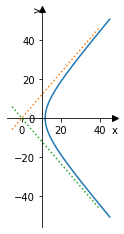

In [10]:
user_data = input_data("""6 * (E ** t) + 6 * (E ** (-t))
7 * (E ** t) - 7 * (E ** (-t))""")

x = user_data.read_expression("x = ")
y = user_data.read_expression("y = ")

f = parametric_function(x, y)

print("\033[95mАсимптоты:")
display(*f.find_asymptotes()) 

f.draw_with_asymptotes(-2, 2, -5, 40)